In [1]:
import os, math, cv2, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

warnings.filterwarnings('ignore')
print("TensorFlow version:", tf.__version__)


2025-10-07 10:55:47.062604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759834547.273082      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759834547.327216      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


In [2]:
DATA_ROOT = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/"

yes_dir = os.path.join(DATA_ROOT, "yes")
no_dir = os.path.join(DATA_ROOT, "no")

data = []
for label, folder in enumerate(["yes", "no"]):
    folder_path = os.path.join(DATA_ROOT, folder)
    for file in os.listdir(folder_path):
        if file.endswith(('.jpg', '.png', '.jpeg')):
            data.append([os.path.join(folder_path, file), folder])

df = pd.DataFrame(data, columns=['path', 'label'])
print("Total samples:", len(df))
print(df['label'].value_counts())
df.head()


Total samples: 179
label
no     92
yes    87
Name: count, dtype: int64


,path,label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
1,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
2,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
3,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
4,/kaggle/input/brain-mri-images-for-brain-tumor...,yes


In [ ]:
def show_images(filepaths, titles=None, cols=4, figsize=(12,6)):
    rows = math.ceil(len(filepaths)/cols)
    plt.figure(figsize=figsize)
    for i, fp in enumerate(filepaths):
        img = plt.imread(fp)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        if titles: plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

sample_yes = df[df.label=='yes'].sample(4)['path'].tolist()
sample_no = df[df.label=='no'].sample(4)['path'].tolist()
show_images(sample_yes + sample_no, titles=['Tumor']*4 + ['No Tumor']*4, cols=4)


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(f"Training: {len(train_df)}, Validation: {len(val_df)}")


Training: 143, Validation: 36


In [5]:
IMG_SIZE = (224, 224)
BATCH = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
val_datagen = ImageDataGenerator(preprocessing_function=eff_preprocess)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label',
    target_size=IMG_SIZE, class_mode='binary',
    batch_size=BATCH, shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label',
    target_size=IMG_SIZE, class_mode='binary',
    batch_size=BATCH, shuffle=False
)


Found 143 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base for transfer learning

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1759834560.771301      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = dict(zip(np.unique(train_df['label']), class_weights))
print("Class Weights:", class_weights)

EPOCHS = 20
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights  # ✅ Added class weighting
)


Class Weights: {'no': 0.9794520547945206, 'yes': 1.0214285714285714}
Epoch 1/20


I0000 00:00:1759834581.736122      98 service.cc:148] XLA service 0x7cbe40003080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759834581.736789      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759834583.564000      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/5 ━━━━━━━━━━━━━━━━━━━━ 1:43 26s/step - accuracy: 0.3750 - loss: 0.7307

I0000 00:00:1759834592.093509      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.4633 - loss: 0.7323 - val_accuracy: 0.7222 - val_loss: 0.6394
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.6509 - loss: 0.6483 - val_accuracy: 0.7222 - val_loss: 0.6142
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.7741 - loss: 0.5739 - val_accuracy: 0.8056 - val_loss: 0.5692
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.6643 - loss: 0.6075 - val_accuracy: 0.8889 - val_loss: 0.5307
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.7230 - loss: 0.5538 - val_accuracy: 0.8889 - val_loss: 0.5006
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.7634 - loss: 0.5171 - val_accuracy: 0.8889 - val_loss: 0.4793
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.8358 - loss: 0.4973 - val_accuracy: 0.8889 - val_loss: 0.4594
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.7951 - loss: 0.4870 - val_accuracy: 0.9167 - val_loss: 0.4457
Epoch

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-50]:  # ✅ Fine-tune deeper layers
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights
)


Epoch 1/20


E0000 00:00:1759834682.641380     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759834682.846498     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759834683.159631     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759834683.364768     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/5 ━━━━━━━━━━━━━━━━━━━━ 2:25 36s/step - accuracy: 0.6667 - loss: 0.4985

E0000 00:00:1759834695.304086      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759834695.511020      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759834695.826706      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759834696.033639      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.6998 - loss: 0.5018 - val_accuracy: 0.8889 - val_loss: 0.3462
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.6809 - loss: 0.5241 - val_accuracy: 0.8889 - val_loss: 0.3420
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.7419 - loss: 0.5618 - val_accuracy: 0.8889 - val_loss: 0.3380
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.7657 - loss: 0.4763 - val_accuracy: 0.8889 - val_loss: 0.3340
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.8455 - loss: 0.3879 - val_accuracy: 0.9167 - val_loss: 0.3305
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.8266 - loss: 0.4217 - val_accuracy: 0.9167 - val_loss: 0.3278
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.7947 - loss: 0.4619 - val_accuracy: 0.9167 - val_loss: 0.3247
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - accuracy: 0.7419 - loss: 0.4766 - val_accuracy: 0.9167 - val_loss: 0.3212
Epoch

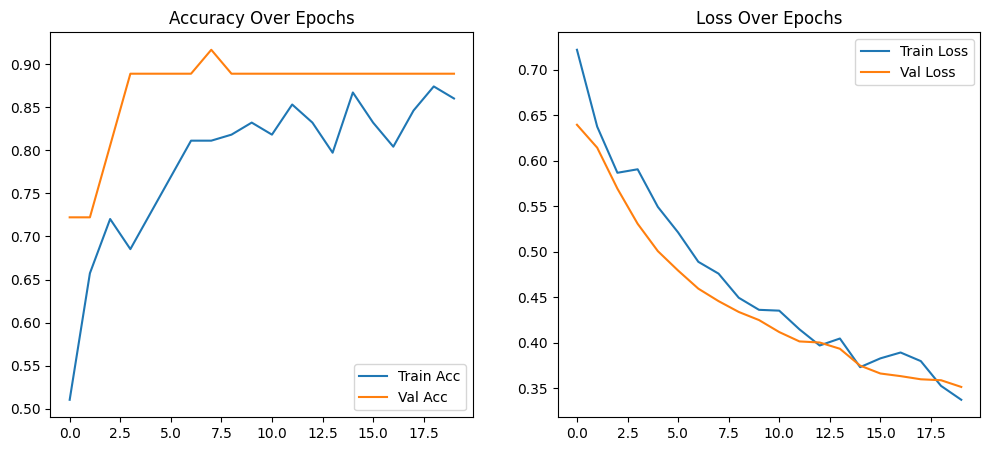

In [9]:
def plot_training(history, fine_tune_history=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if fine_tune_history:
        acc += fine_tune_history.history['accuracy']
        val_acc += fine_tune_history.history['val_accuracy']
        loss += fine_tune_history.history['loss']
        val_loss += fine_tune_history.history['val_loss']

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    plt.show()

plot_training(history)


In [10]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in model.")

last_conv_layer_name = find_last_conv_layer(model)
print("Last convolution layer:", last_conv_layer_name)


Last convolution layer: top_conv


In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(filepath):
    img = keras.preprocessing.image.load_img(filepath, target_size=IMG_SIZE)
    x = keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = eff_preprocess(x)

    preds = model.predict(x)
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)

    heatmap = cv2.resize(heatmap, IMG_SIZE)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    orig = cv2.imread(filepath)
    orig = cv2.resize(orig, IMG_SIZE)
    overlay = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap='jet'); plt.title('Heatmap'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title('Overlay'); plt.axis('off')
    plt.show()

    print(f"Predicted Tumor Probability: {float(preds[0,0]):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


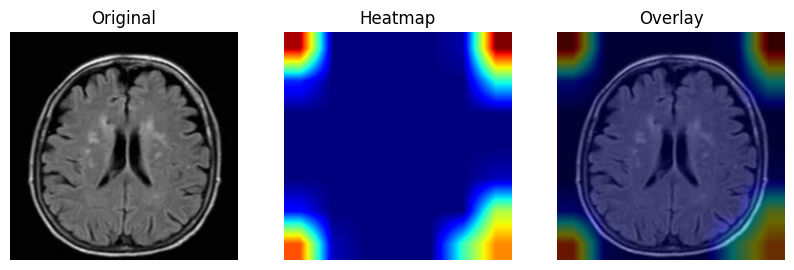

Predicted Tumor Probability: 0.0368
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


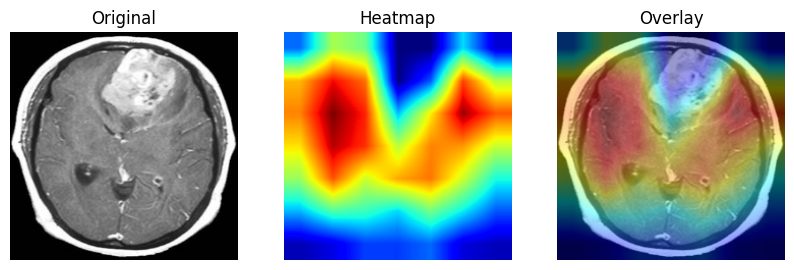

Predicted Tumor Probability: 0.9463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


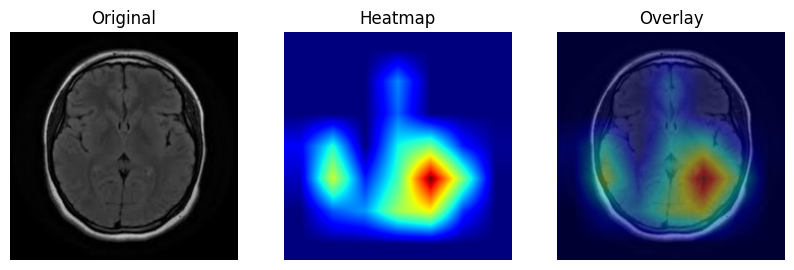

Predicted Tumor Probability: 0.3212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


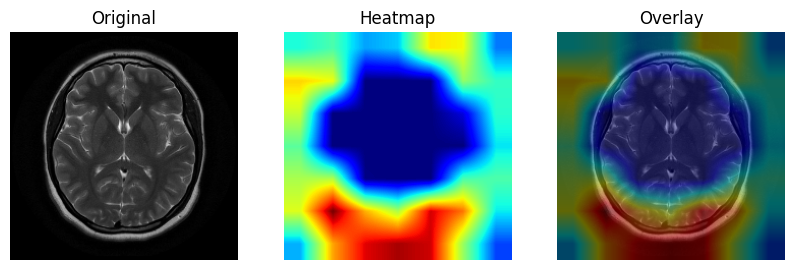

Predicted Tumor Probability: 0.2001


In [12]:
sample_files = val_df.sample(4)['path'].tolist()
for fp in sample_files:
    display_gradcam(fp)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


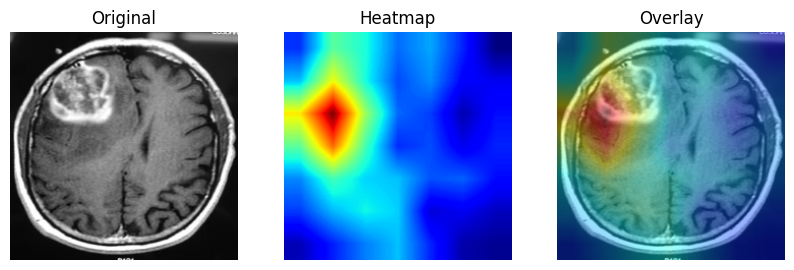

Predicted Tumor Probability: 0.9718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


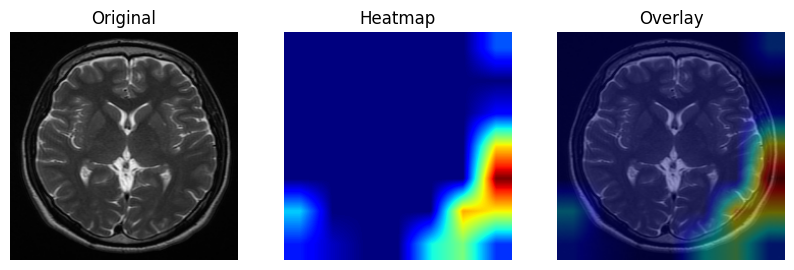

Predicted Tumor Probability: 0.0712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


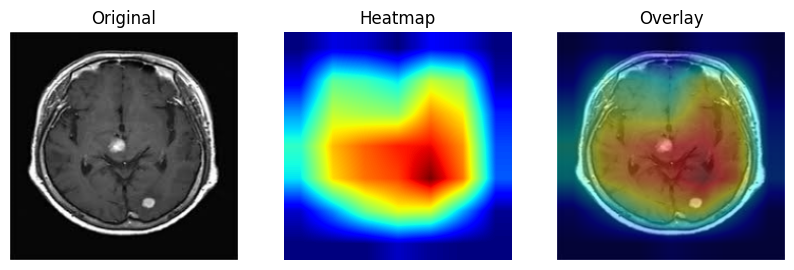

Predicted Tumor Probability: 0.9250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


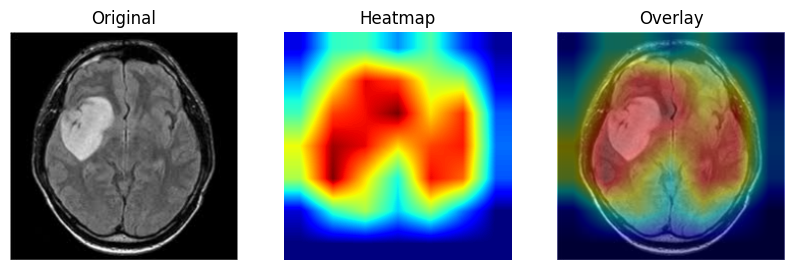

Predicted Tumor Probability: 0.7968


In [13]:
sample_files = val_df.sample(4)['path'].tolist()
for fp in sample_files:
    display_gradcam(fp)


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step
ROC-AUC Score: 0.9536
Confusion Matrix:
 [[16  3]
 [ 1 16]]


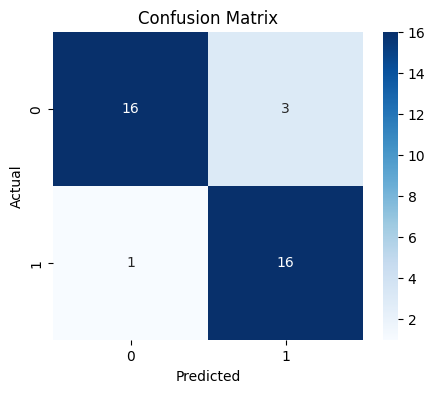

In [14]:
from sklearn.metrics import roc_auc_score, confusion_matrix

y_true = val_gen.classes
y_pred = model.predict(val_gen).ravel()

roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC-AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))
print("Confusion Matrix:\n", cm)

import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
